# Some statistics to choose the input resolution for your InChI predictor

Analysis of train and test images (random sample) in the [Bristol-Myers Squibb – Molecular Translation Competition](https://www.kaggle.com/c/bms-molecular-translation) to find a suitable input image ratio and resolution.

**Credits: I adapted the crop function from https://www.kaggle.com/markwijkhuizen/advanced-image-cleaning-and-tfrecord-generation (great TFRecord kernel!)**

Hi everyone!

I've seen different choices of the image resolution and w/h ratio so far, some use squares, some rectangles. I did this analysis to learn more about the images we are given, especially after they are cropped. Note that image width and height are swapped if height > width, for orginal versions as well as cropped versions.

**In the end you can find a summary with the fractions of images that need to be 'shrinked' after cropping for different input resolutions together with the mean 'shrink factor' and more statistics for each resolution.**

In this summary width / height ratios of around 2 seems to work best. What ratio and image resolution did you choose as input for your InChI prediction model? What were the reasons?

Feel free to comment below and / or leave a vote if you find this kernel helpful :)

In [1]:
DEBUG = False
IMAGE_NUM = 1000 if DEBUG else 1_300_000
EXAMPLE_NUM = 2 if DEBUG else 5

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()

import cv2
import imageio
import os
import sys
import re
import seaborn as sns
import time
import random
import pickle
       
SEED = round(time.time())
print(f'SEED: {SEED}')
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

SEED: 1620283005


In [2]:
# sorting again after sampling seems to make the file access slightly faster for large IMAGE_NUM
train_ids = pd.read_csv('/kaggle/input/bms-molecular-translation/train_labels.csv', dtype={'image_id': 'string', 'InChI': 'string'}).sample(n=IMAGE_NUM).sort_values(by='image_id', ignore_index=True).image_id
test_ids = pd.read_csv('/kaggle/input/bms-molecular-translation/sample_submission.csv', usecols=['image_id'], dtype={'image_id': 'string'}).sample(n=IMAGE_NUM).sort_values(by='image_id', ignore_index=True).image_id

# Adapted crop function

The crop function from the original source above was adapted to ignore noise pixels and thus crop the real molecule structure only without removing the noise first.

In [3]:
def crop(img, contour_min_size=2, small_stuff_size=2, small_stuff_dist=5, pad_pixels=1, debug=False, my_figsize=(12,6), horizontal=True):
    
    # idea: pad with contour_min_size pixels just in case we cut off
    #       a small part of the structure that is separated by a missing pixel
    
    # rotate counter clockwise to get horizontal images
    h, w = img.shape
    if h > w:
        img = np.rot90(img)
    
    if debug:
        if horizontal:
            fig, ax = plt.subplots(1,2, figsize=my_figsize)
        else:
            fig, ax = plt.subplots(2,1, figsize=my_figsize)
        ax[0].imshow(img)
        ax[0].set_title(f'original image, shape: {img.shape}', size=16)
        
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    
    small_stuff = []
    
    x_min0, y_min0, x_max0, y_max0 = np.inf, np.inf, 0, 0
    for cnt in contours:
        if len(cnt) < contour_min_size:  # ignore contours under contour_min_size pixels
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        if w <= small_stuff_size and h <= small_stuff_size:  # collect position of small contours starting with contour_min_size pixels
            small_stuff.append([x, y, x+w, y+h])
            continue
        x_min0 = min(x_min0, x)
        y_min0 = min(y_min0, y)
        x_max0 = max(x_max0, x + w)
        y_max0 = max(y_max0, y + h)
        
    x_min, y_min, x_max, y_max = x_min0, y_min0, x_max0, y_max0
    
    # enlarge the found crop box if it cuts out small stuff that is very close by
    for i in range(len(small_stuff)):
        if small_stuff[i][0] < x_min0 and small_stuff[i][0] + small_stuff_dist >= x_min0:
             x_min = small_stuff[i][0]
        if small_stuff[i][1] < y_min0 and small_stuff[i][1] + small_stuff_dist >= y_min0:
             y_min = small_stuff[i][1]
        if small_stuff[i][2] > x_max0 and small_stuff[i][2] - small_stuff_dist <= x_max0:
             x_max = small_stuff[i][2]
        if small_stuff[i][3] > y_max0 and small_stuff[i][3] - small_stuff_dist <= y_max0:
             y_max = small_stuff[i][3]
                             
    if pad_pixels > 0:  # make sure we get the crop within a valid range
        y_min = max(0, y_min-pad_pixels)
        y_max = min(img.shape[0], y_max+pad_pixels)
        x_min = max(0, x_min-pad_pixels)
        x_max = min(img.shape[1], x_max+pad_pixels)
        
    img_cropped = img[y_min:y_max, x_min:x_max]
    
    if debug:
        ax[1].imshow(img_cropped)
        ax[1].set_title(f'cropped image, shape: {img_cropped.shape}', size=16)
        plt.show()
    
    return img_cropped

In [4]:
def check_cropping(image_id, folder='train', my_figsize=(12,6), horizontal=True):
    print(f'{folder}/{image_id}')
    file_path =  f'/kaggle/input/bms-molecular-translation/{folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.png'
    img = 255 - cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img = crop(img, debug=True, my_figsize=my_figsize, horizontal=horizontal)

# Check cropped train images

train/000011a64c74


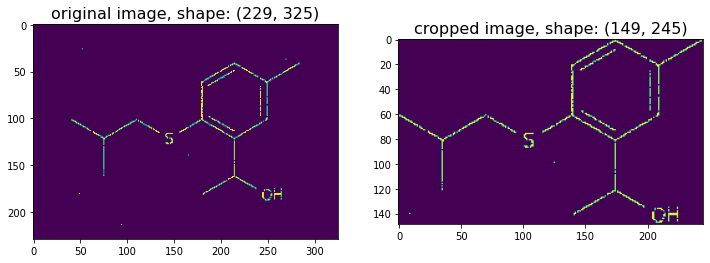

train/000026fc6c36


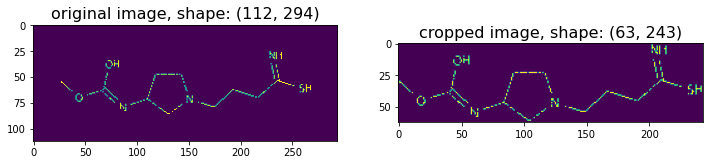

train/000028818203


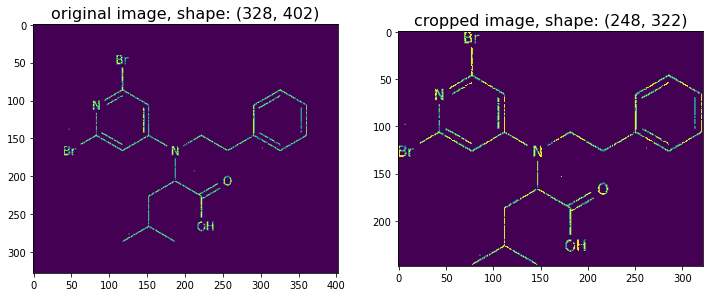

train/00005d8b1ff0


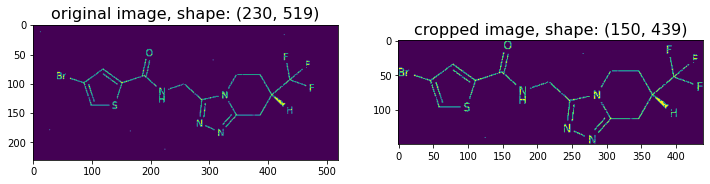

train/00005f2f2dd2


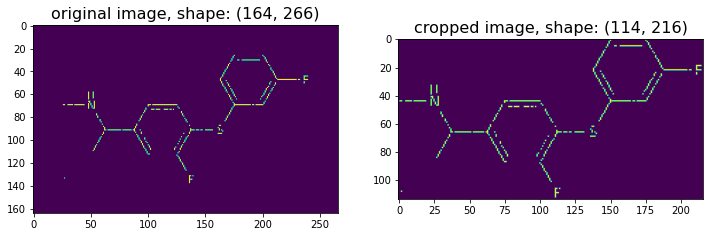

In [5]:
dummy = [check_cropping(image_id, folder='train') for image_id in train_ids[:EXAMPLE_NUM]]

# Check cropped test images

test/00000d2a601c


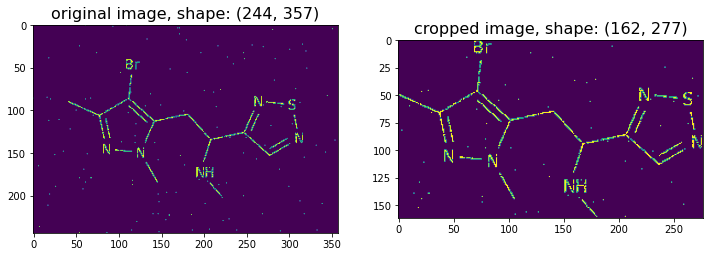

test/00001f7fc849


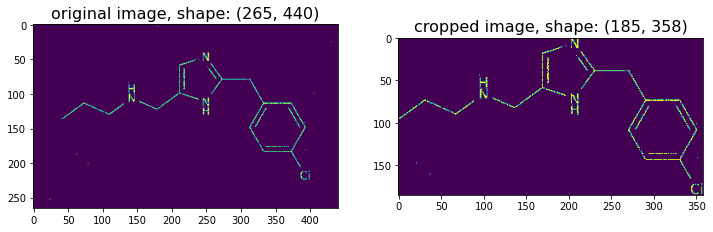

test/000037687605


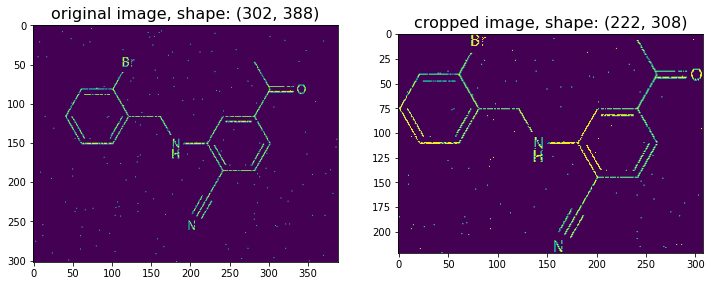

test/00004b6d55b6


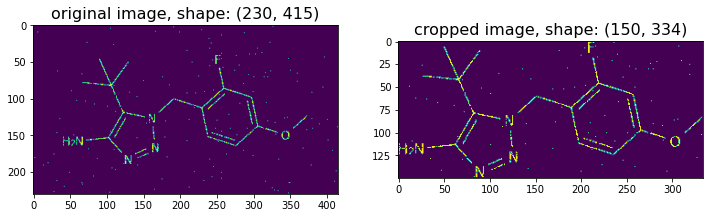

test/00004df0fe53


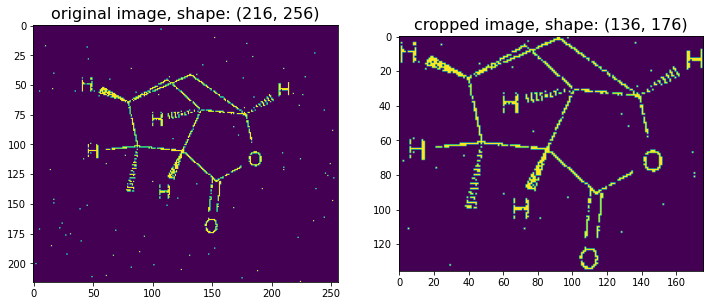

In [6]:
dummy = [check_cropping(image_id, folder='test') for image_id in test_ids[:EXAMPLE_NUM]]

# Image analysis function

Image width and height are swapped if height > width, for orginal versions as well as cropped versions.

In [7]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

def analyse_img_sizes(image_ids, folder='train', plots=False, w_large=500, h_large=250, very_large_factor=1.5):
    ws = []
    hs = []
    ws_c = []
    hs_c = []
    fs = []
    for image_id in tqdm(image_ids):
        file_path =  f'/kaggle/input/bms-molecular-translation/{folder}/{image_id[0]}/{image_id[1]}/{image_id[2]}/{image_id}.png'
        file_size = os.path.getsize(file_path) 
        fs.append(file_size)
        img = 255 - cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # '255 -' need for cropping to work

        h, w = img.shape
        if h > w:
            h, w = w, h
        ws.append(w)
        hs.append(h)

        img_cropped = crop(img)
        h_c, w_c = img_cropped.shape
        if h_c > w_c:
            h_c, w_c = w_c, h_c
        ws_c.append(w_c)
        hs_c.append(h_c)

    img_info = pd.DataFrame({'image_id': image_ids, 'file_size': fs, 'width': ws, 'width_crop': ws_c, 'height': hs, 'height_crop': hs_c})
    
    img_info['area'] = img_info.width * img_info.height
    img_info['area_crop'] = img_info.width_crop * img_info.height_crop
    img_info['ratio'] = img_info.width / img_info.height
    img_info['ratio_crop'] = img_info.width_crop / img_info.height_crop
        
    img_info_large = img_info.loc[np.logical_or(img_info.width_crop > w_large, img_info.height_crop > h_large),:]
    
    img_info_very_large = img_info.loc[np.logical_or(img_info.width_crop > very_large_factor*w_large, img_info.height_crop > very_large_factor*h_large),:]
        
    print(f'statistics for all images')
    display(img_info.describe())
    print()
    print(f"statistics for 'large' images with cropped width > {w_large} or height > {h_large} ({len(img_info_large)/len(img_info)*100:.3}%):")
    display(img_info_large.describe())
    print()
    print(f"statistics for 'very large' images with cropped width > {very_large_factor*w_large} or height > {very_large_factor*h_large} ({len(img_info_very_large)/len(img_info)*100:.3}%):")
    display(img_info_very_large.describe())
    
    if plots:
        print()
        print(f"plots for 'large' and 'very large' images only")
        plot_info =  img_info_large
        sns.jointplot(data=plot_info, x='width', y='height', kind='hist')
        sns.jointplot(data=plot_info, x='file_size', y='area', kind='hist')
        sns.jointplot(data=plot_info, x='width', y='width_crop', kind='hist')
        sns.jointplot(data=plot_info, x='height', y='height_crop', kind='hist')
        sns.jointplot(data=plot_info, x='width_crop', y='height_crop', kind='hist')
        sns.jointplot(data=plot_info, x='ratio', y='ratio_crop', kind='hist')
        sns.jointplot(data=plot_info, x='area_crop', y='ratio_crop', kind='hist')

    return img_info

# Train image statistics 

  0%|          | 0/1300000 [00:00<?, ?it/s]

statistics for all images


,file_size,width,width_crop,height,height_crop,area,area_crop,ratio,ratio_crop
count,1300000.00,1300000.00,1300000.00,1300000.00,1300000.00,1300000.00,1300000.00,1300000.00,1300000.00
mean,1667.99,380.98,315.37,219.85,154.37,90387.01,53495.57,1.78,2.17
std,768.05,135.17,126.14,72.53,63.13,64451.22,48138.68,0.49,0.85
min,363.00,117.00,67.00,68.00,16.00,11466.00,3216.00,1.00,1.00
25%,1066.00,281.00,226.00,163.00,109.00,45894.25,25200.00,1.44,1.62
50%,1514.00,360.00,293.00,211.00,143.00,76232.50,42444.00,1.71,2.04
75%,2083.00,461.00,383.00,262.00,186.00,118496.00,68076.00,2.03,2.56
max,10941.00,2974.00,2894.00,1537.00,1457.00,2648251.00,2393851.00,26.11,85.12



statistics for 'large' images with cropped width > 500 or height > 250 (12.7%):


,file_size,width,width_crop,height,height_crop,area,area_crop,ratio,ratio_crop
count,165641.00,165641.00,165641.00,165641.00,165641.00,165641.00,165641.00,165641.00,165641.00
mean,3005.16,594.59,515.39,333.48,254.39,198583.01,131452.74,1.91,2.31
std,680.63,158.83,159.20,81.09,80.73,100112.59,87450.55,0.85,1.53
min,618.00,305.00,251.00,68.00,16.00,40320.00,10332.00,1.00,1.00
25%,2593.00,500.00,420.00,281.00,202.00,159034.00,98088.00,1.33,1.42
50%,2958.00,592.00,513.00,337.00,258.00,182490.00,117438.00,1.70,1.90
75%,3356.00,644.00,564.00,371.00,291.00,210915.00,140712.00,2.31,2.83
max,10941.00,2974.00,2894.00,1537.00,1457.00,2648251.00,2393851.00,26.11,85.12



statistics for 'very large' images with cropped width > 750.0 or height > 375.0 (0.849%):


,file_size,width,width_crop,height,height_crop,area,area_crop,ratio,ratio_crop
count,11035.00,11035.00,11035.00,11035.00,11035.00,11035.00,11035.00,11035.00,11035.00
mean,3823.12,926.94,850.60,442.72,366.91,412731.58,314302.56,2.64,3.48
std,1336.48,354.24,354.34,183.21,182.23,285172.41,255972.24,2.05,4.10
min,852.00,441.00,382.00,68.00,16.00,66424.00,16096.00,1.00,1.00
25%,2971.50,657.00,580.00,303.00,225.00,254893.00,174755.00,1.28,1.32
50%,3782.00,872.00,797.00,463.00,384.00,312390.00,225792.00,1.94,2.10
75%,4430.00,1053.00,976.00,509.00,434.00,437208.00,338409.00,3.16,3.94
max,10941.00,2974.00,2894.00,1537.00,1457.00,2648251.00,2393851.00,26.11,85.12



plots for 'large' and 'very large' images only


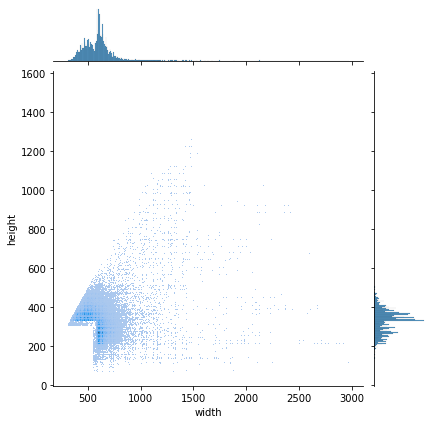

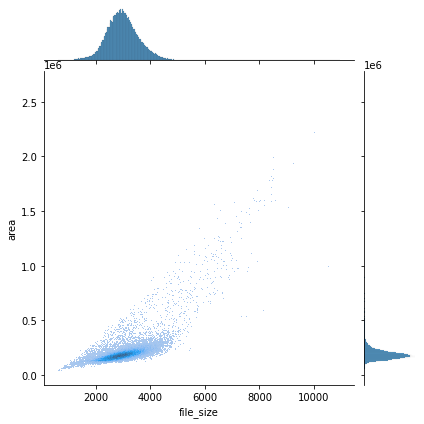

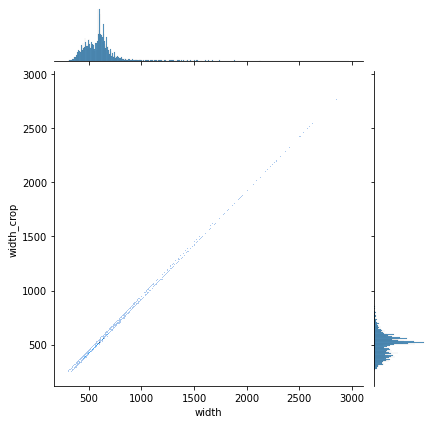

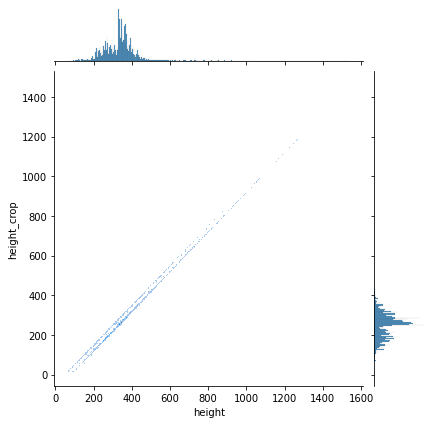

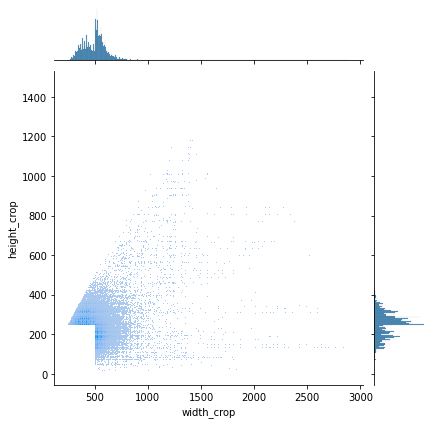

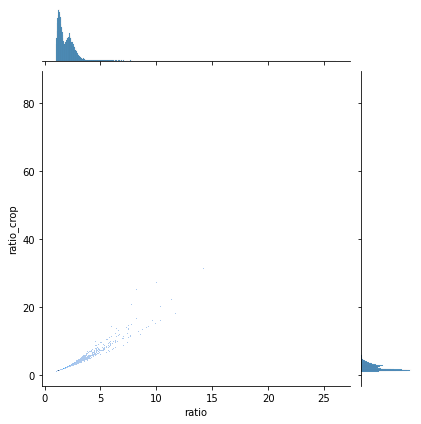

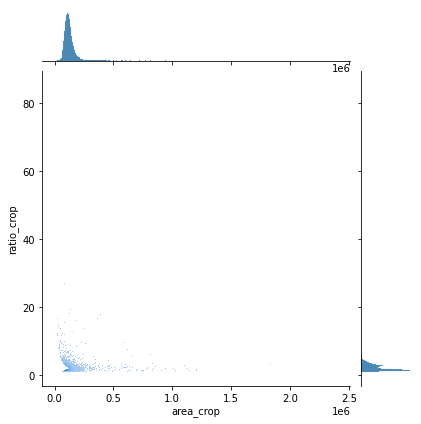

In [8]:
train_img_info = analyse_img_sizes(train_ids, folder='train', plots=not DEBUG)

with open('train_img_info.pkl', 'wb') as handle:
    pickle.dump(train_img_info, handle)

# Test image statistics 

  0%|          | 0/1300000 [00:00<?, ?it/s]

statistics for all images


,file_size,width,width_crop,height,height_crop,area,area_crop,ratio,ratio_crop
count,1300000.00,1300000.00,1300000.00,1300000.00,1300000.00,1300000.00,1300000.00,1300000.00,1300000.00
mean,1945.63,381.01,315.47,219.78,154.39,90305.40,53461.52,1.78,2.17
std,967.80,134.88,125.85,72.22,62.81,63477.02,47152.48,0.49,0.85
min,356.00,114.00,64.00,68.00,15.00,11439.00,3225.00,1.00,1.00
25%,1210.00,281.00,226.00,163.00,110.00,45920.00,25228.00,1.44,1.62
50%,1728.00,360.00,294.00,211.00,143.00,76176.00,42456.00,1.71,2.03
75%,2458.00,460.00,383.00,262.00,186.00,118500.00,68160.00,2.03,2.56
max,19365.00,3010.00,2930.00,1434.00,1354.00,2354628.00,2114948.00,25.56,81.89



statistics for 'large' images with cropped width > 500 or height > 250 (12.8%):


,file_size,width,width_crop,height,height_crop,area,area_crop,ratio,ratio_crop
count,165774.00,165774.00,165774.00,165774.00,165774.00,165774.00,165774.00,165774.00,165774.00
mean,3588.08,594.73,515.59,332.74,253.79,197872.20,130883.98,1.92,2.31
std,1004.36,157.01,157.41,79.89,79.54,95885.23,83621.42,0.85,1.54
min,650.00,302.00,251.00,68.00,15.00,39192.00,9538.00,1.00,1.00
25%,2986.00,501.00,421.00,280.00,201.00,159034.00,98136.00,1.33,1.42
50%,3477.00,592.00,513.00,337.00,258.00,182400.00,117316.00,1.71,1.91
75%,4041.00,644.00,565.00,371.00,291.00,210834.75,140686.50,2.32,2.85
max,19365.00,3010.00,2930.00,1434.00,1354.00,2354628.00,2114948.00,25.56,81.89



statistics for 'very large' images with cropped width > 750.0 or height > 375.0 (0.84%):


,file_size,width,width_crop,height,height_crop,area,area_crop,ratio,ratio_crop
count,10926.00,10926.00,10926.00,10926.00,10926.00,10926.00,10926.00,10926.00,10926.00
mean,5065.68,923.15,846.88,438.55,362.95,404672.74,307124.29,2.66,3.51
std,2235.75,350.44,350.76,178.35,177.39,271256.38,243420.37,2.08,4.12
min,823.00,456.00,376.00,68.00,18.00,57439.00,16362.00,1.00,1.00
25%,3751.00,658.00,580.25,303.00,225.00,255190.00,175362.75,1.28,1.32
50%,4658.00,871.50,796.00,463.00,384.00,311136.00,225003.00,1.97,2.14
75%,5786.75,1052.00,973.00,506.00,430.00,432799.00,330675.25,3.16,3.94
max,19365.00,3010.00,2930.00,1434.00,1354.00,2354628.00,2114948.00,25.56,81.89



plots for 'large' and 'very large' images only


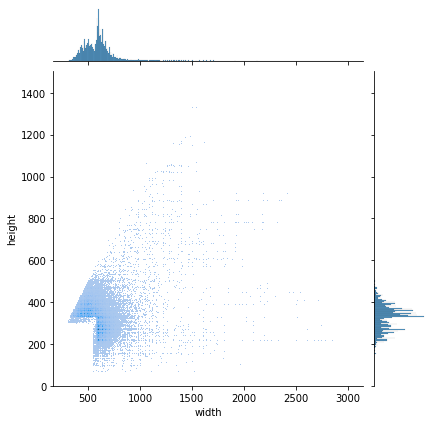

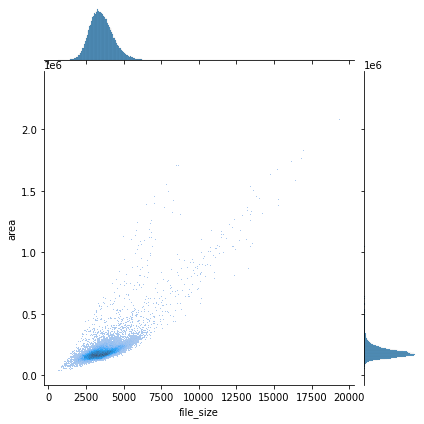

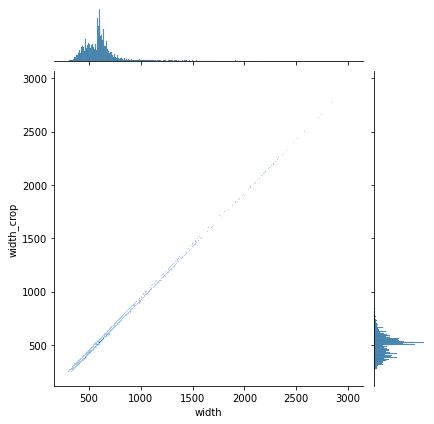

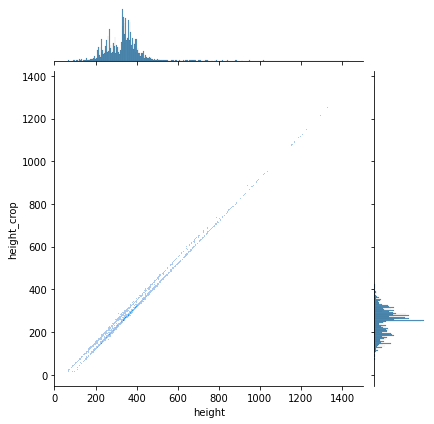

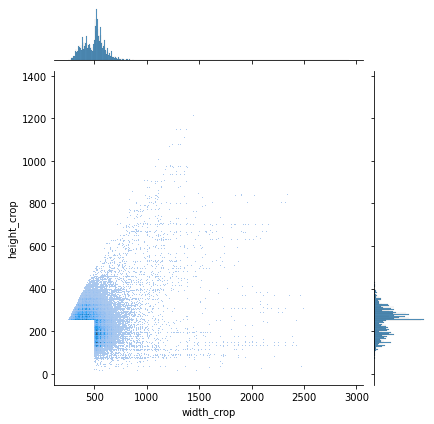

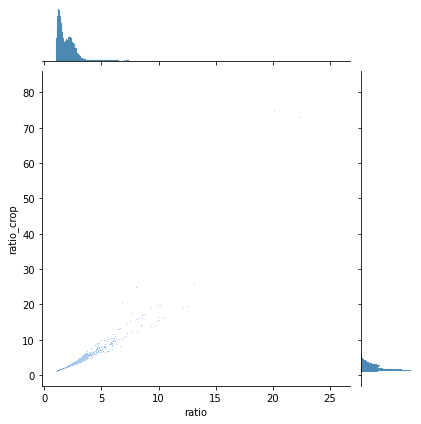

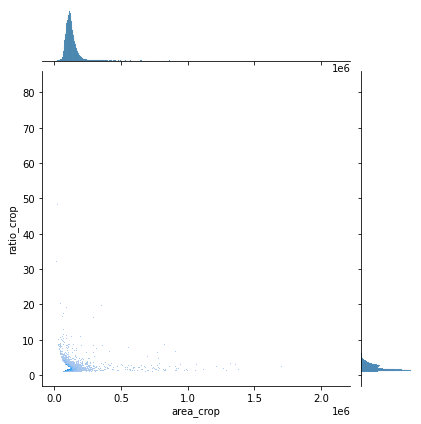

In [9]:
test_img_info = analyse_img_sizes(test_ids, folder='test', plots=not DEBUG)

with open('test_img_info.pkl', 'wb') as handle:
    pickle.dump(test_img_info, handle)

# Images with extremly low width or height

There are some images with extremly low height after cropping. Checking if crop function made a mistake... Seems legit.

very low height images (after swapping if height > width)
train/9055e2634959


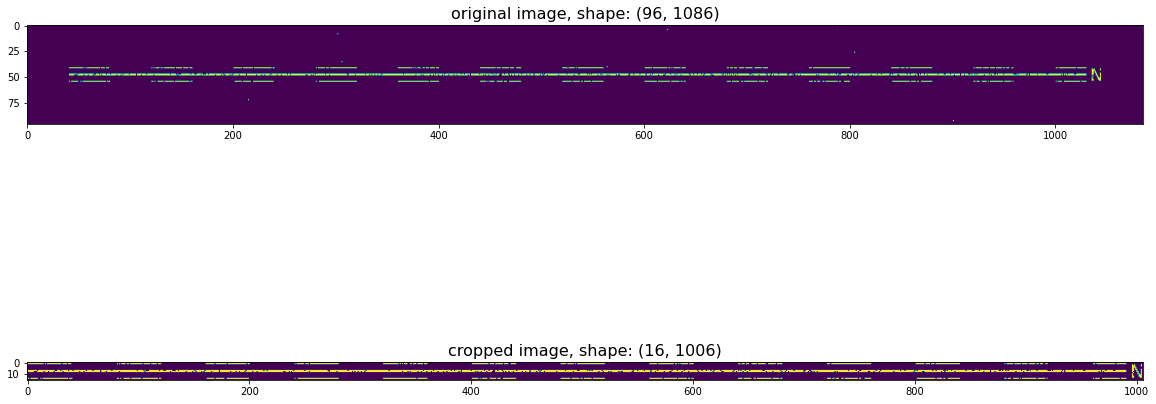

train/50a7c4040423


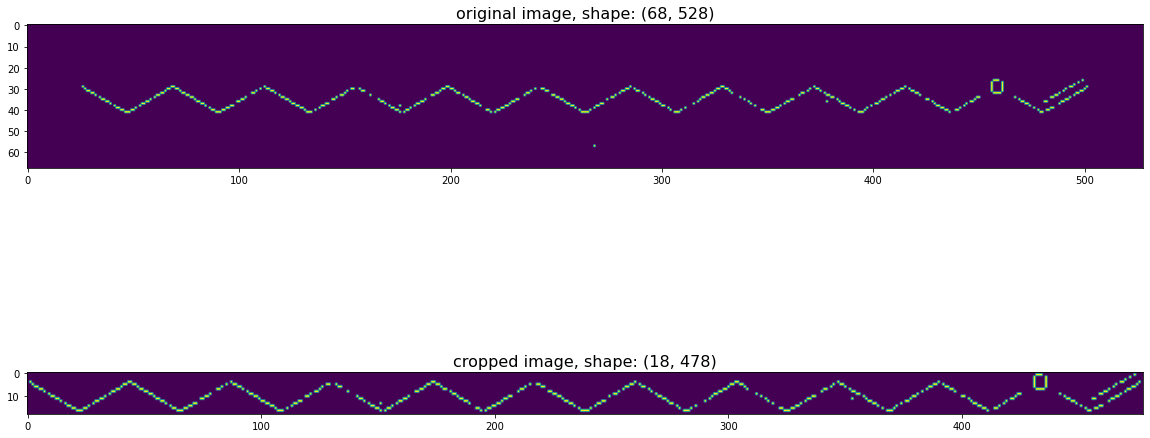

train/c4c32cee6a9a


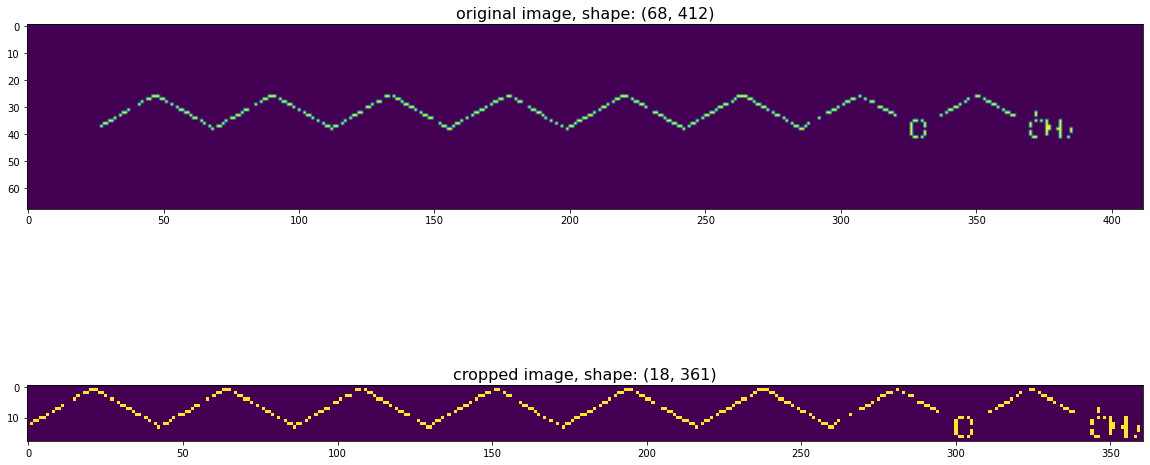

train/6dd8eb7a2a67


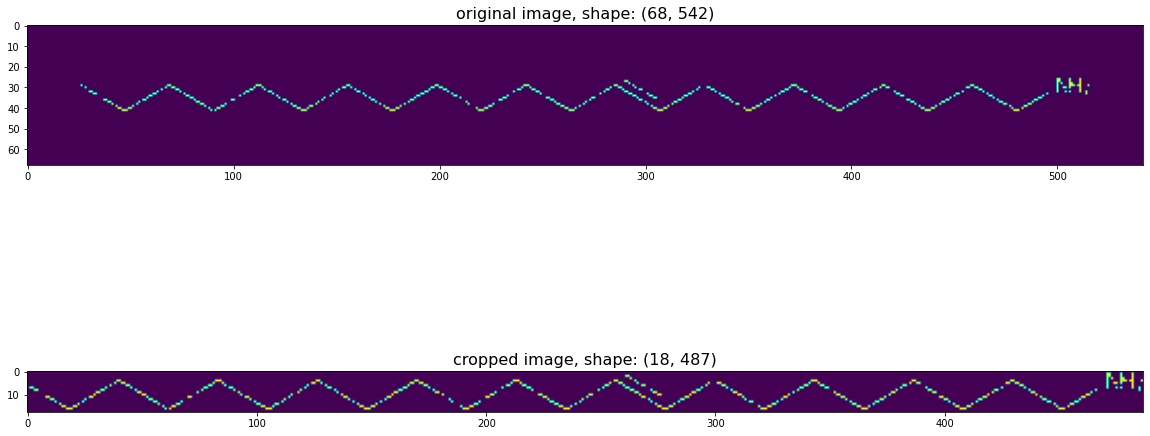

train/44e013f8eb1a


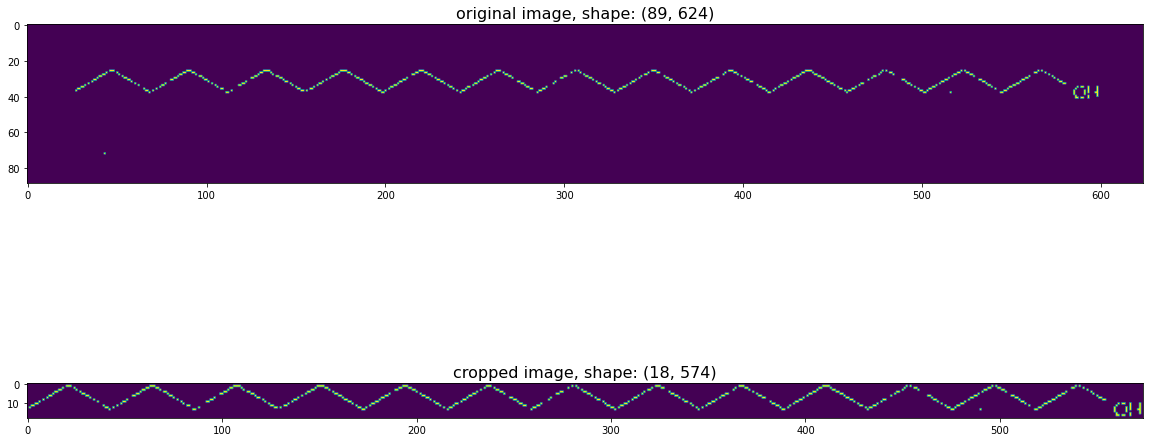

very low width images (after swapping if height > width)
train/3873f14c4b90


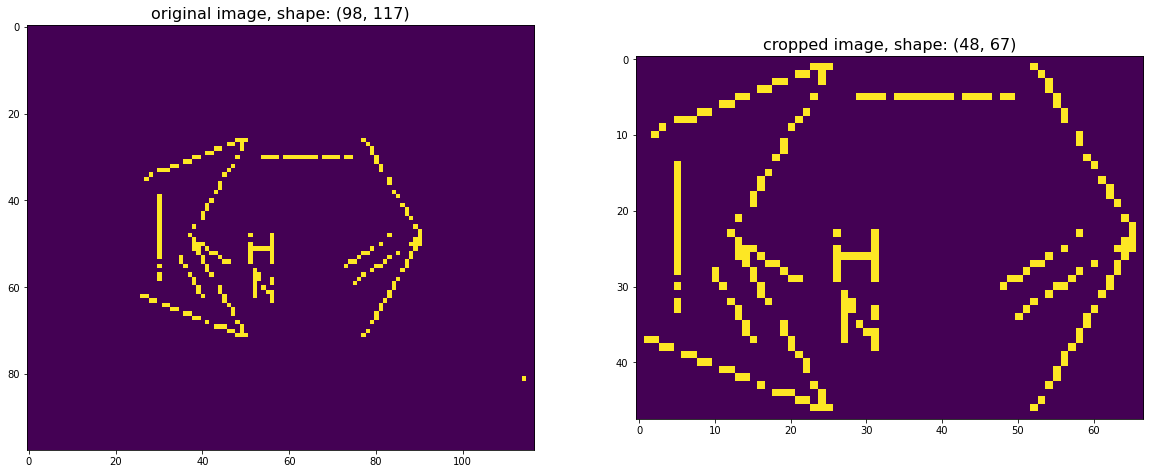

train/1d41aae32457


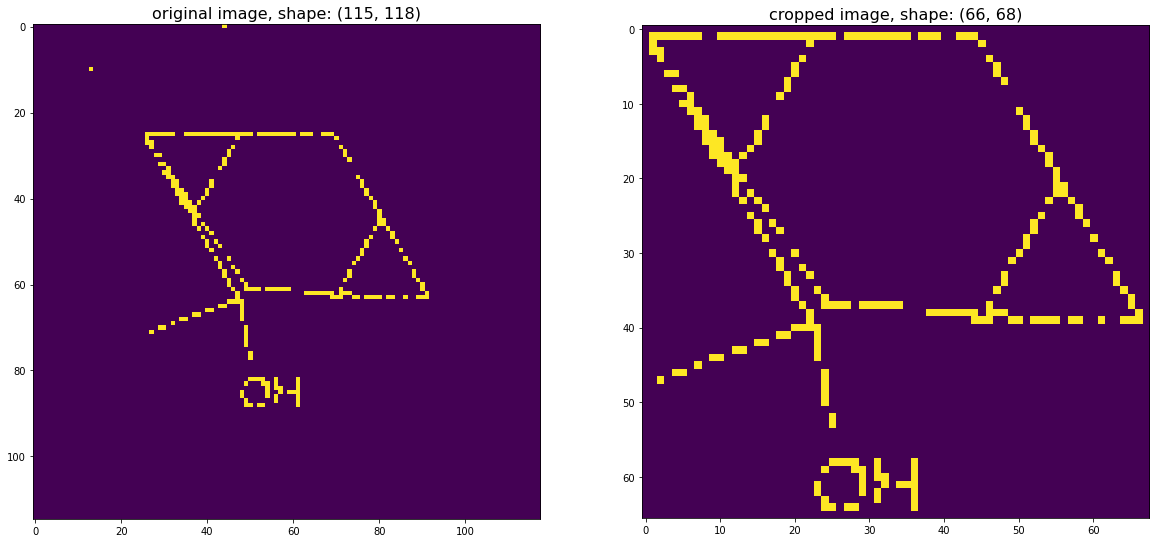

train/48c26fdf3c57


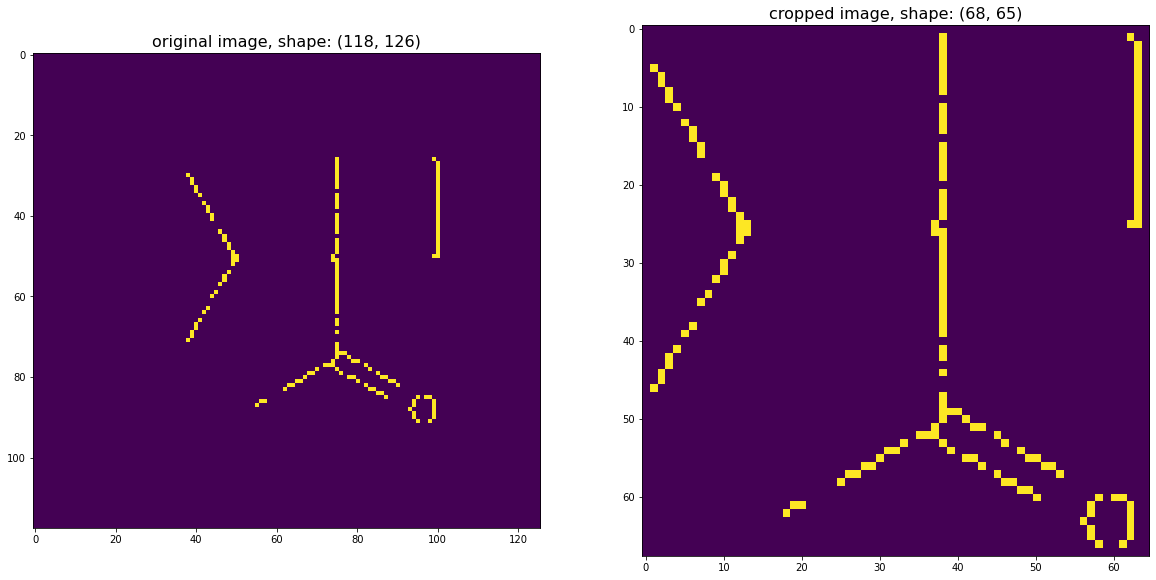

train/394cd9d05ffd


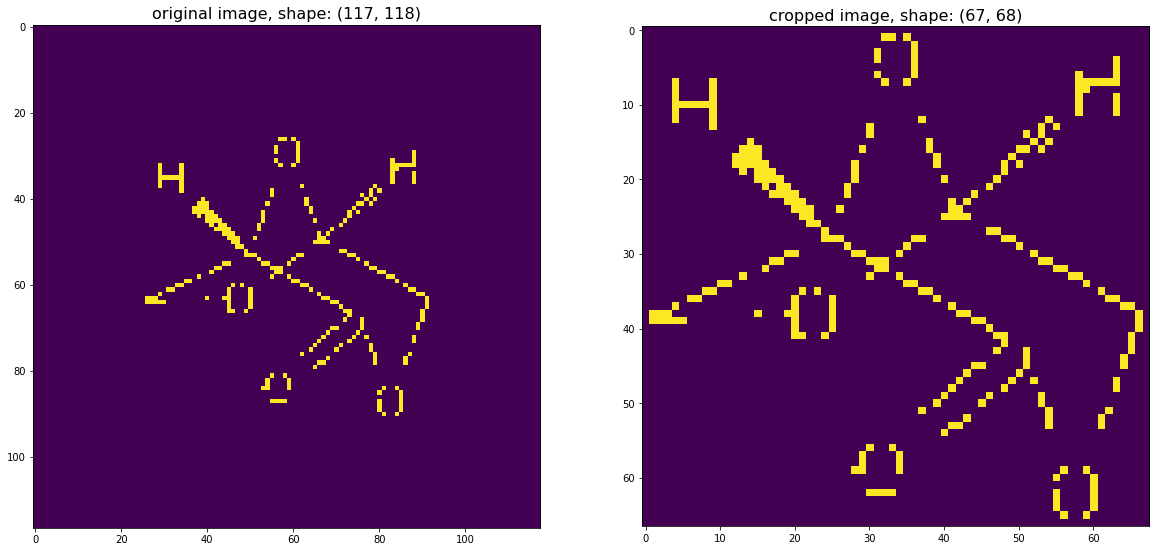

train/56c143556164


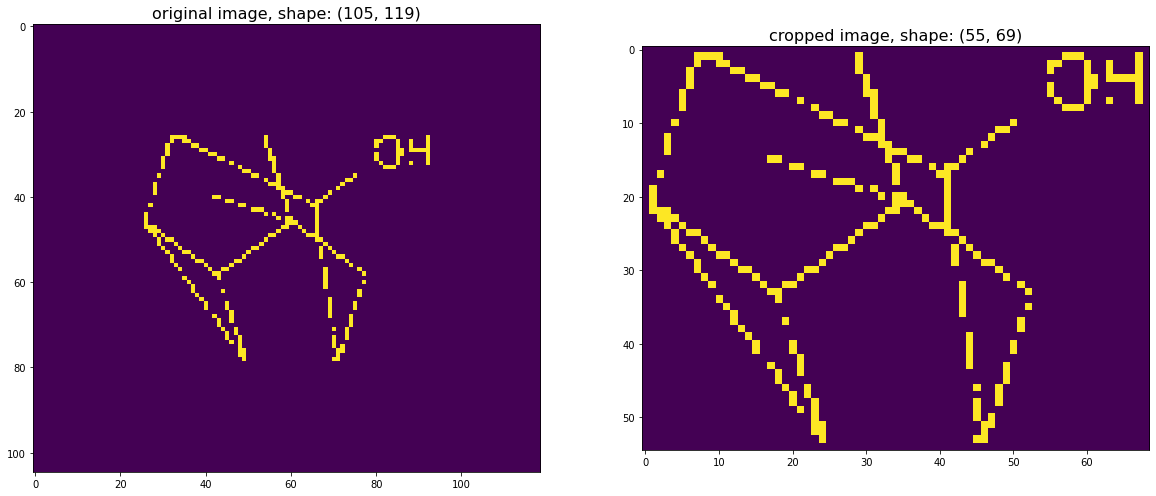

In [10]:
def plot_extreme_images(img_info, folder='train', my_figsize = (20, 10)):
    img_info_width = img_info.sort_values(by='width_crop', ignore_index=True)[:EXAMPLE_NUM]
    img_info_height = img_info.sort_values(by='height_crop', ignore_index=True)[:EXAMPLE_NUM]
    
    print('very low height images (after swapping if height > width)')
    [check_cropping(image_id, folder=folder, my_figsize=my_figsize, horizontal=False) for image_id in img_info_height.image_id]
    
    print('very low width images (after swapping if height > width)')
    [check_cropping(image_id, folder=folder, my_figsize=my_figsize) for image_id in img_info_width.image_id]

plot_extreme_images(train_img_info)

very low height images (after swapping if height > width)
test/012b5dbe50c5


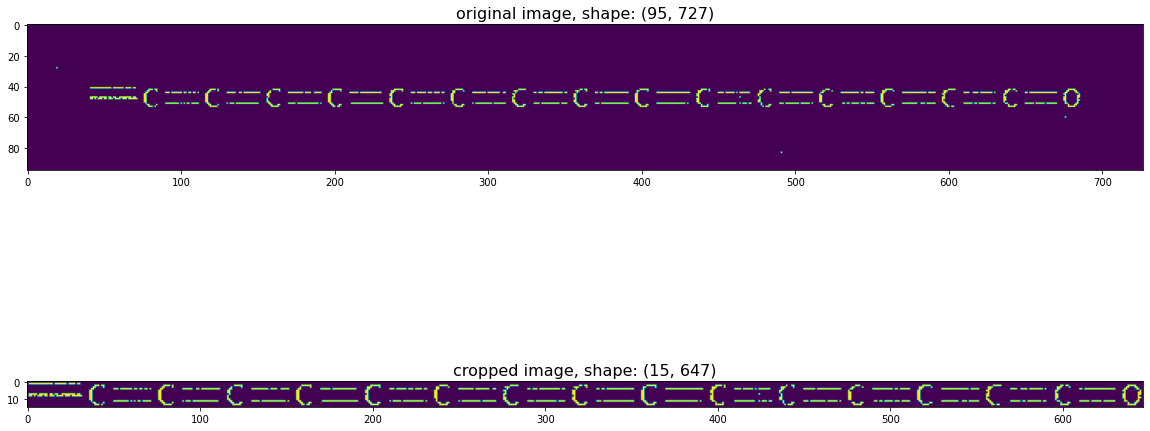

test/3a5a51ec4057


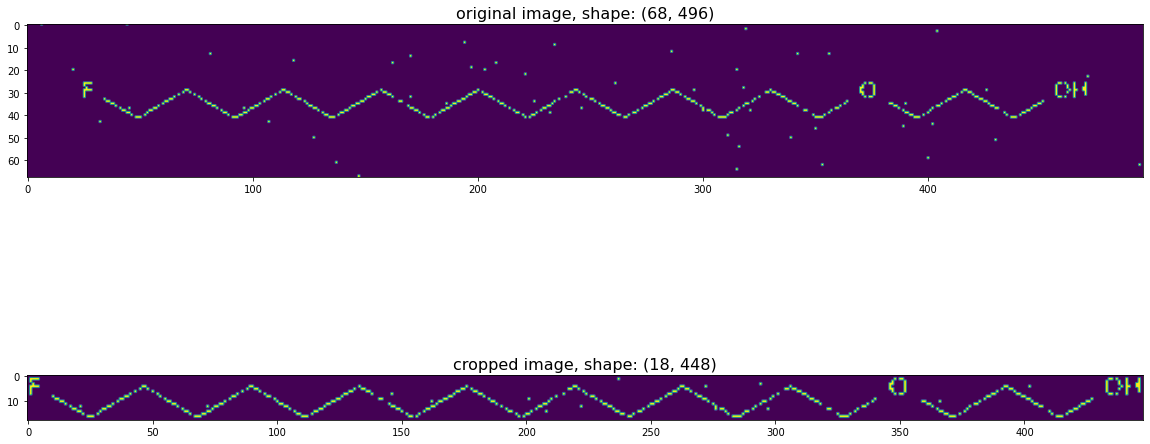

test/0751adb551c0


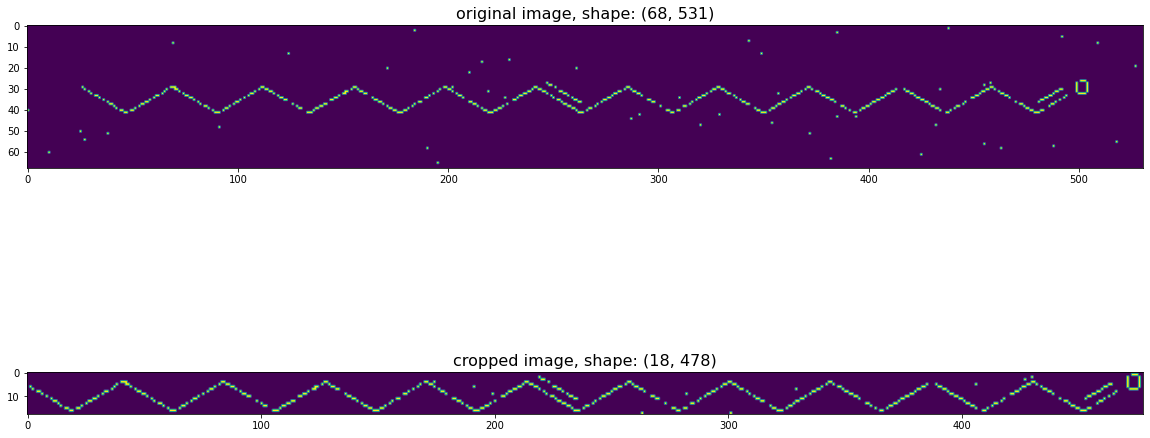

test/3ceeb664266e


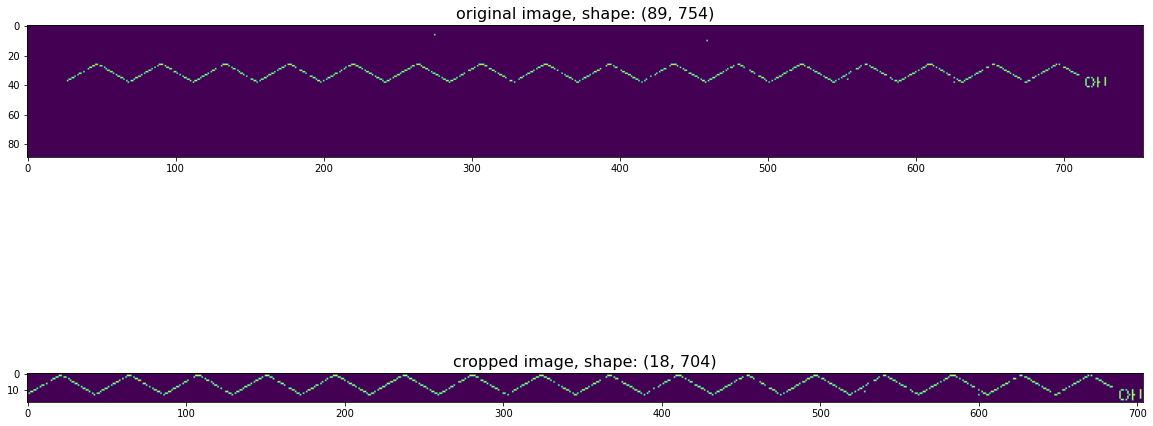

test/772d12ecca63


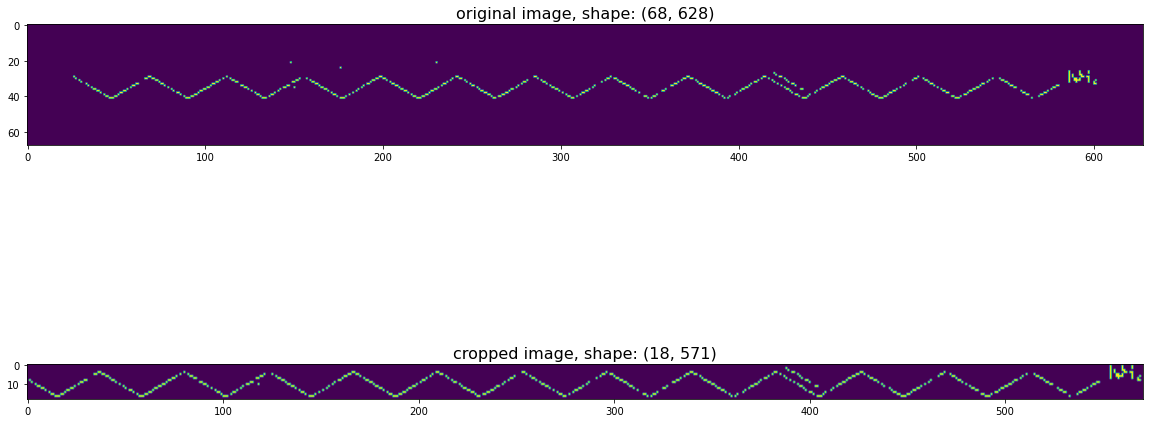

very low width images (after swapping if height > width)
test/b6ad89d95bb6


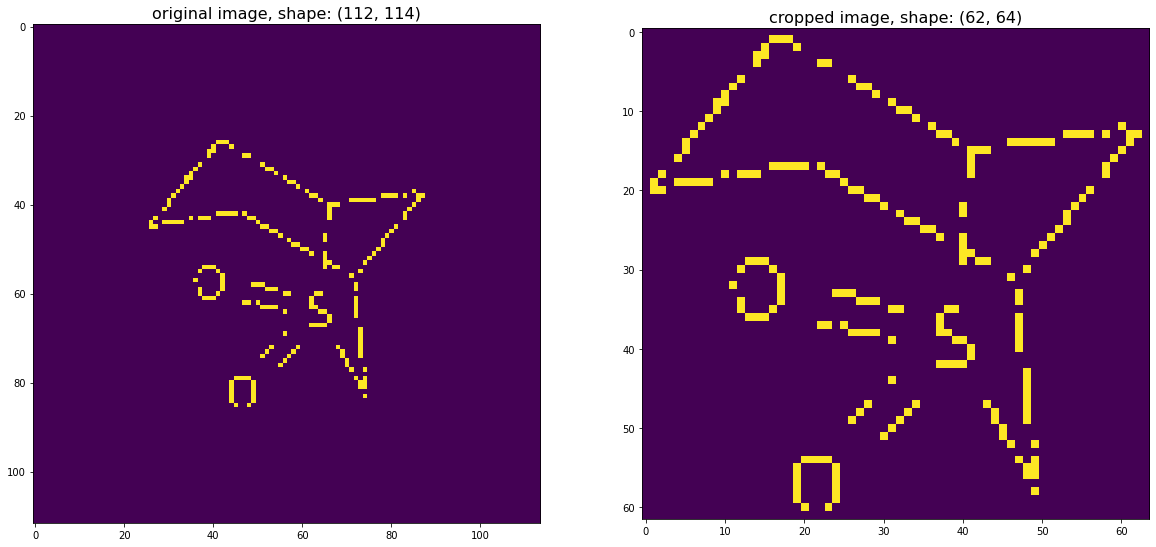

test/ece15a13ba2e


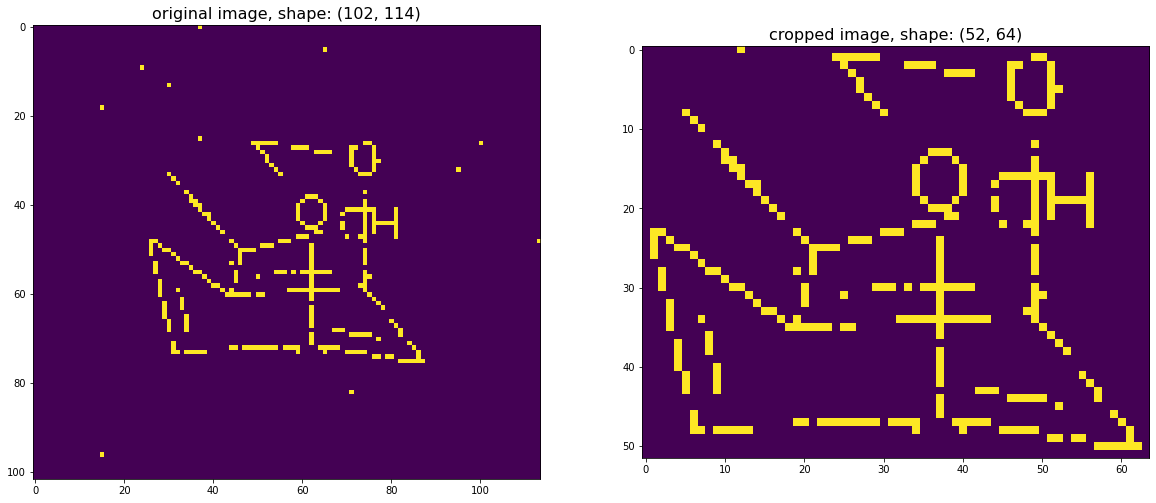

test/daaa7cb369a0


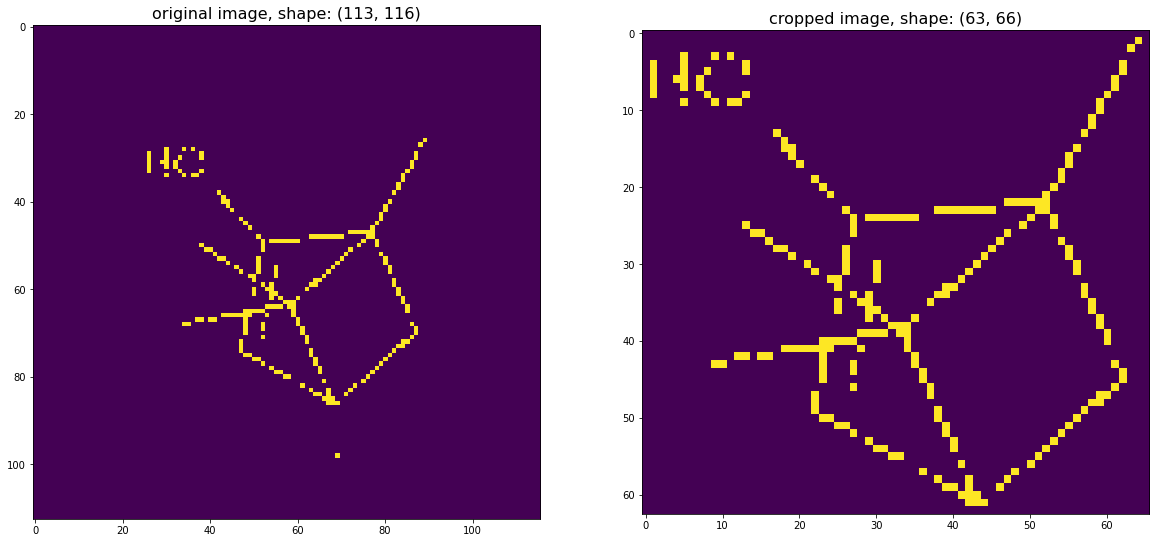

test/0111e04fe1c2


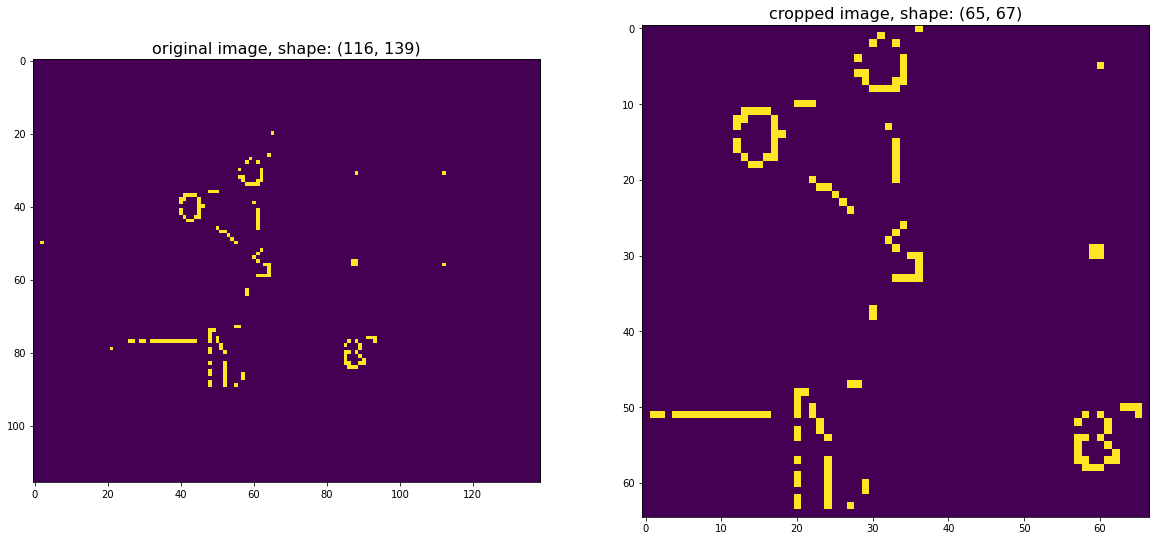

test/b41d81e5d088


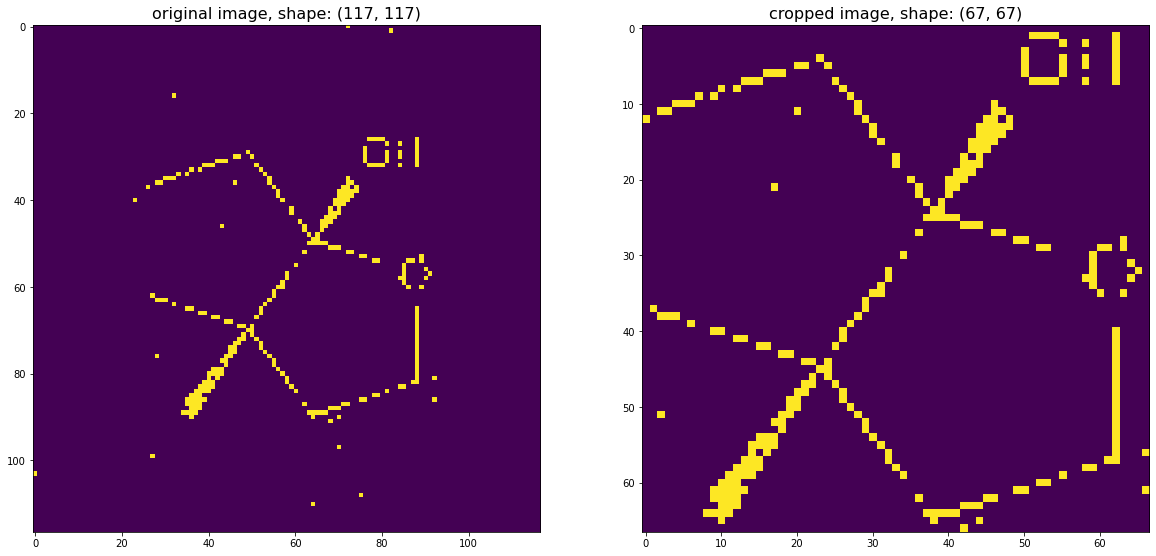

In [11]:
plot_extreme_images(test_img_info, folder='test')

# Find best input resolution

In [12]:
input_ratios = [1, 1.25, 1.5, 1.75, 1.9, 2, 2.1, 2.25, 2.5]

def get_res(pixels, ratio):
    pixels = pixels**0.5
    ratio = ratio**0.5
    return (round(pixels*ratio), round(pixels/ratio))

base_pixels = 320*320
input_sizes = [get_res(base_pixels, r) for r in input_ratios]

base_pixels = 448*256
input_sizes += [get_res(base_pixels, r) for r in input_ratios]

base_pixels = 512*256
input_sizes += [get_res(base_pixels, r) for r in input_ratios]

base_pixels = 384*384
input_sizes += [get_res(base_pixels, r) for r in input_ratios]

pixels = [w*h for w, h in input_sizes]
input_ratios = [w/h for w, h in input_sizes]

def calc_shrink_factors(current_width, current_height, input_size):
    if current_width < input_size[0] and current_height < input_size[1]:
        return 1
    else:
        return max(input_size[0]/current_width, input_size[1]/current_height)

def check_resolutions(img_info):

    mean_shrink_factors = []  # mean shrink factor (largest of the two factors to decrease image width and/or height to fit the image into the input size, 1 if image fits already)
    rms_shrink_factors = []  # root mean square 
    mean_shrink_factors_over_1 = []
    rms_shrink_factors_over_1 = []
    fraction_shrinked = []

    for input_size in input_sizes:
        shrink_factors = np.array([calc_shrink_factors(train_img_info.width_crop[i], train_img_info.height_crop[i], input_size) for i in range(len(train_img_info))])
        mean_shrink_factors.append(np.mean(shrink_factors))
        rms_shrink_factors.append(np.mean(shrink_factors**2)**0.5)
        temp = shrink_factors>1
        fraction_shrinked.append(np.mean(temp))
        mean_shrink_factors_over_1.append(np.mean(shrink_factors[temp]))
        rms_shrink_factors_over_1.append(np.mean(shrink_factors[temp]**2)**0.5)
        
    return(pd.DataFrame({'resolution': input_sizes, 'pixels': pixels, 'input_ratio': input_ratios, 'frac_shrinked': fraction_shrinked, 
                        'mean_shr_factor': mean_shrink_factors, 'rms_shr_factor': rms_shrink_factors, 'mean_shr_fac_over_1': mean_shrink_factors_over_1, 
                        'rms_shr_fac_over_1': rms_shrink_factors_over_1}))

pd.set_option('display.float_format', lambda x: '%.3f' % x)

print('train images')
display(check_resolutions(train_img_info))

print('test images')
display(check_resolutions(test_img_info))

train images


,resolution,pixels,input_ratio,frac_shrinked,mean_shr_factor,rms_shr_factor,mean_shr_fac_over_1,rms_shr_fac_over_1
0,"(320, 320)",102400,1.000,0.396,1.356,1.483,1.905,2.010
1,"(358, 286)",102388,1.252,0.274,1.178,1.247,1.663,1.746
2,"(392, 261)",102312,1.502,0.200,1.093,1.130,1.491,1.561
3,"(423, 242)",102366,1.748,0.164,1.056,1.077,1.375,1.431
4,"(441, 232)",102312,1.901,0.154,1.045,1.061,1.328,1.375
5,"(453, 226)",102378,2.004,0.151,1.042,1.057,1.314,1.356
6,"(464, 221)",102544,2.100,0.149,1.040,1.054,1.305,1.344
7,"(480, 213)",102240,2.254,0.158,1.045,1.059,1.319,1.354
8,"(506, 202)",102212,2.505,0.180,1.062,1.080,1.368,1.404
9,"(339, 339)",114921,1.000,0.347,1.330,1.460,1.955,2.065


test images


,resolution,pixels,input_ratio,frac_shrinked,mean_shr_factor,rms_shr_factor,mean_shr_fac_over_1,rms_shr_fac_over_1
0,"(320, 320)",102400,1.000,0.396,1.356,1.483,1.905,2.010
1,"(358, 286)",102388,1.252,0.274,1.178,1.247,1.663,1.746
2,"(392, 261)",102312,1.502,0.200,1.093,1.130,1.491,1.561
3,"(423, 242)",102366,1.748,0.164,1.056,1.077,1.375,1.431
4,"(441, 232)",102312,1.901,0.154,1.045,1.061,1.328,1.375
5,"(453, 226)",102378,2.004,0.151,1.042,1.057,1.314,1.356
6,"(464, 221)",102544,2.100,0.149,1.040,1.054,1.305,1.344
7,"(480, 213)",102240,2.254,0.158,1.045,1.059,1.319,1.354
8,"(506, 202)",102212,2.505,0.180,1.062,1.080,1.368,1.404
9,"(339, 339)",114921,1.000,0.347,1.330,1.460,1.955,2.065
